In [2]:

import pandas as pd
import matplotlib
import os
# os.environ['TRANSFORMERS_OFFLINE'] = '1' # Indicating transformers for offline mode

from functools import partial

from pathlib import Path

from tokenizers import Tokenizer
from transformers import AutoTokenizer, AutoModel
import transformers
from transformers.models.auto.tokenization_auto import logger

import random

import torch
import torchmetrics
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl





transformers.logging.set_verbosity_error()
TRANSFORMER_CACHE = Path("../resources/transformer_cache") # The cache location. Accessed when offline.

#### Model

In [3]:
class CHUNKSUMM(pl.LightningModule):
    def __init__(self, model, learning_rate=6e-5, n_classes=2, enable_chunk=False):
        super().__init__()

        self.bert = model

        # Freezing bert params
        # for param in self.bert.parameters():
        #     param.requires_grad = False
        # self.bert.eval()

        self.criterion = nn.BCEWithLogitsLoss()
        self.l1 = torch.nn.Linear(768, n_classes)
        self.learning_rate = learning_rate
        self.accuracy = torchmetrics.Accuracy()
        self.auc = torchmetrics.AUROC(num_classes=n_classes)
        self.enable_chunk = enable_chunk
       
        # self.save_hyperparameters() # Saves every *args in _init_() in checkpoint file. # Slows trainer.predict
        self.save_hyperparameters(ignore=["bert"])




    def forward(self, input_ids, attention_mask, token_type_ids, train=False):
        """Can handle more than 512 tokens"""

        embed2d = self.get_embedding(input_ids, attention_mask, token_type_ids)
        logits = self.l1(embed2d)  
        if train:
            return logits
        else: 
            return torch.softmax(logits,dim=-1)




    def get_embedding(self, input_ids, attention_mask, token_type_ids):

        if self.enable_chunk:

            batch_chunks = [
                self.chunk(batch) for batch in (input_ids, attention_mask, token_type_ids)
            ]
            handler = []
            for chunk in zip(batch_chunks[0], batch_chunks[1], batch_chunks[2]):

                chunk_hidden_states = self.bert(chunk[0], chunk[1], chunk[2], output_hidden_states=True)[2]
                chunk_embed2d = torch.stack(chunk_hidden_states)[-5:].mean(0)
                handler.append(chunk_embed2d)

            contextual_encoding = torch.cat(handler, dim=1)
            embed2d = contextual_encoding

        else:
            hidden_states = self.bert(input_ids[:, :512], attention_mask[:, :512], token_type_ids[:, :512], output_hidden_states=True)[2]
            mean_hidden_states = torch.stack(hidden_states)[-5:].mean(0)
            contextual_encoding = mean_hidden_states
            embed2d = contextual_encoding

        return embed2d

    def training_step(self, batch, batch_ids=None):



        outputs = self(batch["input_ids"], batch["attention_mask"], batch["token_type_ids"],train=True)

        labels = self.expand_targets(batch["targets"].float()) 
        labels = labels.reshape_as(outputs)


        loss = self.criterion(outputs, labels) 
        #acc = self.accuracy(outputs, labels.int())
        auc = self.auc(outputs, labels.int())


        
        self.log("Loss_train", loss, prog_bar=True, logger=True)
        self.log("Auc_train", auc, prog_bar=True, logger=True)

        return {"loss": loss, "predictions": outputs, "labels": labels}



    def validation_step(self, batch, batch_idx):

        outputs = self(
            batch["input_ids"], batch["attention_mask"], batch["token_type_ids"])
        labels = self.expand_targets(batch["targets"].float()) 
        labels = labels.reshape_as(outputs)


        loss = self.criterion(outputs,labels)   

        auc = self.auc(outputs, labels.int())

        self.log("Loss_val", loss, prog_bar=True, logger=True)
        self.log("Auc_val", auc, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):

        outputs = self(batch["input_ids"], batch["attention_mask"], batch["token_type_ids"])
        labels = self.expand_targets(batch["targets"].float()) 
        labels = labels.reshape_as(outputs)

        loss = self.criterion(outputs, labels)
        #acc = self.accuracy(outputs, labels.int())
        auc = self.auc(outputs, labels.int())

        self.log("Test_loss", loss, prog_bar=True, logger=True)
        self.log("Test_auc", auc, prog_bar=True, logger=True)

        return loss

    def predict_step(self, batch, batch_ids, dataloader_idx=None):

        outputs = self(
            batch["input_ids"], batch["attention_mask"], batch["token_type_ids"]
        )

        return outputs
    

    def configure_optimizers(self):

        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    @property
    def chunk(self):
        return partial(torch.split, split_size_or_sections=512, dim=1)

    def expand_targets(self,targets):
        """This returns the Two dimentional targets given the single correct label"""
        # 0 -> [0,1]  , 1 -> [1,0] =  (IN,OUT) class.
        out = torch.stack([torch.tensor([1.,0.]) if val else torch.tensor([0.,1.])  for batch in  targets.bool() for val in batch])
      
        return out.to(self.device)

In [4]:
# This is required to initialize the backend-model (bert) which is a pretrained model.
  
pretrained_model = AutoModel.from_pretrained('../resources/checkpoints/bert-base-uncased.pt')
tokenizer = AutoTokenizer.from_pretrained('../resources/checkpoints/bert-base-uncased-tokenizer.pt')


/home/amanjais/projects/def-emilios/dsci_2022/ENV/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


#### Load Checkpoints

In [10]:

#loading model checkpoint

first = torch.load('../resources/checkpoints/first.pt') # initial model
second_40k = torch.load('../resources/checkpoints/second-40k.pt') # Traning with 40k sentences


first_model = CHUNKSUMM(model=pretrained_model,enable_chunk=True)
first_model.load_state_dict(first) 
second_model = CHUNKSUMM(model=pretrained_model,enable_chunk=True)
second_model.load_state_dict(second_40k)

def get_token_scores(model,tokenizer,text:[str]):

    tokenized_input = tokenizer(text,return_tensors='pt')
    model = model.eval()

    return tokenized_input['input_ids'],model(**tokenized_input) # (IN,OUT) probabilities


/home/amanjais/projects/def-emilios/dsci_2022/ENV/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Inference

In [11]:

batch_text = "This is a test"* 700

tokens,probs = get_token_scores(first_model,tokenizer,batch_text)

In [12]:
tokens.shape # batch * tokens   

torch.Size([1, 3501])

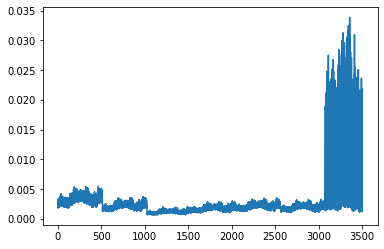

In [14]:
probs[:,:,0].shape # batch * tokens * probability

import matplotlib.pyplot as plt


plt.plot(probs[:,:,0][0].detach().numpy())  # first model probs

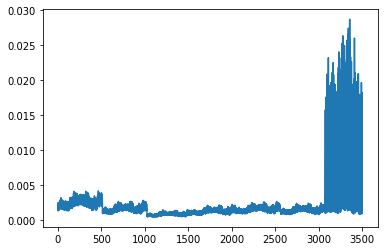

In [15]:
tokens,probs = get_token_scores(second_model,tokenizer,batch_text)

plt.plot(probs[:,:,0][0].detach().numpy())  # second model probs

#### Long-Text

In [12]:
long_text = """The story revolves around a girl called Little Red Riding Hood. In Perrault's versions of the tale, she is named after her red hooded cape/cloak that she wears. The girl walks through the woods to deliver food to her sickly grandmother (wine and cake depending on the translation). In the Grimms' version, her mother had ordered her to stay strictly on the path.

A stalking wolf wants to eat the girl and the food in the basket. He asks her where she is going. She tells him. He suggests that she pick some flowers as a present for her grandmother, which she does. In the meantime, he goes to the grandmother's house and gains entry by pretending to be her. He swallows the grandmother whole (in some stories, he locks her in the closet) and waits for the girl, disguised as the grandmother.


Gustave Doré's engraving of the scene: "She was astonished to see how her grandmother looked."
When the girl arrives, she notices that her grandmother looks very strange. She says, "What a deep voice you have!" ("The better to greet you with", responds the wolf), "Goodness, what big eyes you have!" ("The better to see you with", responds the wolf), "And what big hands you have!" ("The better to embrace you with", responds the wolf), and lastly, "What a big mouth you have" ("The better to eat you with!", responds the wolf), at which point the wolf jumps out of the bed and eats her, too. Then he falls asleep. In Charles Perrault's version of the story (the first version to be published), the tale ends here.

In later and better-known versions, the story continues. A woodcutter in the French version, or a hunter in the Brothers Grimm and traditional German versions, comes to the rescue with an axe, and cuts open the sleeping wolf. Little Red Riding Hood and her grandmother emerge shaken, but unharmed. Then they fill the wolf's body with heavy stones. The wolf awakens and attempts to flee, but the stones cause him to collapse and die. In the Grimms' version, the wolf leaves the house and tries to drink out of a well, but the stones in his stomach cause him to fall in and drown (similarly to the story of "The Wolf and the Seven Little Kids").

Sanitized versions of the story have the grandmother locked in the closet instead of being eaten and some have Little Red Riding Hood saved by the lumberjack as the wolf advances on her rather than after she is eaten, where the woodcutter kills the wolf with his axe.[4]


"Little Red Riding Hood" illustration by Arthur Rackham.[5]
History
Relationship to other tales
The story displays many similarities to stories from classical Greece and Rome. Scholar Graham Anderson has compared the story to a local legend recounted by Pausanias in which, each year, a virgin girl was offered to a malevolent spirit dressed in the skin of a wolf, who raped the girl. Then, one year, the boxer Euthymos came along, slew the spirit, and married the girl who had been offered as a sacrifice.[6] There are also a number of different stories recounted by Greek authors involving a woman named Pyrrha (literally "fire") and a man with some name meaning "wolf".[7] The Roman poet Horace alludes to a tale in which a male child is rescued alive from the belly of Lamia, an ogress in classical mythology.[8]

The dialogue between the wolf and Little Red Riding Hood has analogies to the Norse Þrymskviða from the Elder Edda; the giant Þrymr had stolen Mjölnir, Thor's hammer, and demanded Freyja as his bride for its return. Instead, the gods dressed Thor as a bride and sent him. When the giants note Thor's unladylike eyes, eating, and drinking, Loki explains them as Freyja's not having slept, eaten, or drunk, out of longing for the wedding.[9] A parallel to another Norse myth, the chase and eventual murder of the sun goddess by the wolf Sköll, has also been drawn.[10]

A similar story also belongs to the North African tradition, namely in Kabylia, where a number of versions are attested.[11] The theme of the little girl who visits her (grand)dad in his cabin and is recognized by the sound of her bracelets constitutes the refrain of a well-known song by the modern singer Idir, "A Vava Inouva":

‘I beseech you, open the door for me, father.
Jingle your bracelets, oh my daughter Ghriba.
I'm afraid of the monster in the forest, father.
I, too, am afraid, oh my daughter Ghriba.’[12]
The theme of the ravening wolf and of the creature released unharmed from its belly is also reflected in the Russian tale Peter and the Wolf and another Grimm tale The Wolf and the Seven Young Kids, but its general theme of restoration is at least as old as the biblical story, Jonah and the Whale. The theme also appears in the story of the life of Saint Margaret, wherein the saint emerges unharmed from the belly of a dragon, and in the epic "The Red Path" by Jim C. Hines.

A Taiwanese story from the 16th century, known as Grandaunt Tiger bears several striking similarities. In this story there are two girls who are sisters. When the girls' mother goes out, the tigress comes to the girls' house and pretends to be their aunt, asking to come in. One girl says that the aunt's voice does not sound right, so the tigress attempts to disguise her voice. Then, the girl says that the aunt's hands feel too coarse, so the tigress attempts to make her paws smoother. When finally the tigress gains entry, she eats the girl's sister's hand. The girl comes up with a ruse to go outside and fetch some food for her aunt. Grandaunt Tiger, suspicious of the girl, ties a rope to her leg. The girl ties a bucket to the rope to fool her, but Grandaunt Tiger realises this and chases after her, whereupon she climbs into a tree. The girl tells the tigress that she will let her eat her, but first she would like to feed her some fruit from the tree. The tigress comes closer to eat the fruit, whereupon the girl pours boiling hot oil down her throat, killing her.[13]

According to Paul Delarue, a similar narrative is found in East Asian stories, namely, in China, Korea[14] and Japan, with the title "The Tiger and the Children".[15]

Earliest versions

"The better to see you with": woodcut by Walter Crane
The origins of the Little Red Riding Hood story can be traced to several likely pre-17th century versions from various European countries. Some of these are significantly different from the currently known, Grimms-inspired version. It was told by French peasants in the 10th century[1] and recorded by the cathedral schoolmaster Egbert of Liège.[16] In Italy, Little Red Riding Hood was told by peasants in the fourteenth century, where a number of versions exist, including La finta nonna (The False Grandmother), written among others by Italo Calvino in the Italian Folktales collection.[17] It has also been called "The Story of Grandmother". It is also possible that this early tale has roots in very similar East Asian tales (e.g. "Grandaunt Tiger").[18]

These early variations of the tale, do differ from the currently known version in several ways. The antagonist is not always a wolf, but sometimes a 'bzou' (werewolf), making these tales relevant to the werewolf trials (similar to witch trials) of the time (e.g. the trial of Peter Stumpp).[19][20][21] The wolf usually leaves the grandmother's blood and flesh for the girl to eat, who then unwittingly cannibalizes her own grandmother. Furthermore, the wolf was also known to ask her to remove her clothing and toss it into the fire.[22] In some versions, the wolf eats the girl after she gets into bed with him, and the story ends there.[23] In others, she sees through his disguise and tries to escape, complaining to her "grandmother" that she needs to defecate and would not wish to do so in the bed. The wolf reluctantly lets her go, tied to a piece of string so she does not get away. The girl slips the string over something else and runs off. In these stories she escapes with no help from any male or older female figure, instead using her own cunning, or in some versions the help of a younger boy who she happens to run into.[24] Sometimes, though more rarely, the red hood is even non-existent.[23]

In other tellings of the story, the wolf chases after Little Red Riding Hood. She escapes with the help of some laundresses, who spread a sheet taut over a river so she may escape. When the wolf follows Red over the bridge of cloth, the sheet is released and the wolf drowns in the river.[25] And in another version the wolf is pushed into the fire, while he is preparing the flesh of the grandmother to be eaten by the girl.[23]

Charles Perrault
The earliest known printed version[26] was known as Le Petit Chaperon Rouge and may have had its origins in 17th-century French folklore. It was included in the collection Tales and Stories of the Past with Morals. Tales of Mother Goose (Histoires et contes du temps passé, avec des moralités. Contes de ma mère l'Oye), in 1697, by Charles Perrault. As the title implies, this version[27] is both more sinister and more overtly moralized than the later ones. The redness of the hood, which has been given symbolic significance in many interpretations of the tale, was a detail introduced by Perrault.[28]


French images, like this 19th-century painting, show the much shorter red chaperon being worn
The story had as its subject an "attractive, well-bred young lady", a village girl of the country being deceived into giving a wolf she encountered the information he needed to find her grandmother's house successfully and eat the old woman while at the same time avoiding being noticed by woodcutters working in the nearby forest. Then he proceeded to lay a trap for Red Riding Hood. Little Red Riding Hood ends up being asked to climb into the bed before being eaten by the wolf, where the story ends. The wolf emerges the victor of the encounter and there is no happy ending.

Charles Perrault explained the 'moral' at the end of the tale[29] so that no doubt is left to his intended meaning:

From this story one learns that children, especially young lasses, pretty, courteous and well-bred, do very wrong to listen to strangers, And it is not an unheard thing if the Wolf is thereby provided with his dinner. I say Wolf, for all wolves are not of the same sort; there is one kind with an amenable disposition – neither noisy, nor hateful, nor angry, but tame, obliging and gentle, following the young maids in the streets, even into their homes. Alas! Who does not know that these gentle wolves are of all such creatures the most dangerous!

This, the presumed original version of the tale was written for the late seventeenth-century French court of King Louis XIV. This audience, whom the King entertained with extravagant parties, presumably would take from the story's intended meaning.

The Brothers Grimm

Wilhelm (left) and Jacob Grimm, from an 1855 painting by Elisabeth Jerichau-Baumann
In the 19th century two separate German versions were retold to Jacob Grimm and his younger brother Wilhelm Grimm, known as the Brothers Grimm, the first by Jeanette Hassenpflug (1791–1860) and the second by Marie Hassenpflug (1788–1856). The brothers turned the first version to the main body of the story and the second into a sequel of it. The story as Rotkäppchen was included in the first edition of their collection Kinder- und Hausmärchen (Children's and Household Tales (1812) – KHM 26).[30][31]

The earlier parts of the tale agree so closely with Perrault's variant that it is almost certainly the source of the tale.[32] This version ends with the girl and her grandmother saved by a huntsman who was after the wolf's skin; this ending mirrors that in the tale "The Wolf and the Seven Young Kids", which appears to be the source.[33] The second part featured the girl and her grandmother trapping and killing another wolf, this time anticipating his moves based on their experience with the previous one. The girl did not leave the path when the wolf spoke to her, her grandmother locked the door to keep it out, and when the wolf lurked, the grandmother had Little Red Riding Hood put a trough under the chimney and fill it with water that sausages had been cooked in; the smell lured the wolf down, and it drowned.[34]

The Brothers further revised the story in later editions and it reached the above-mentioned final and better-known version in the 1857 edition of their work.[35] It is notably tamer than the older stories which contained darker themes.

Later versions

An engraving from the Cyclopedia of Wit and Humor.
Numerous authors have rewritten or adapted this tale.

Charles Marelle in his version of the fairy tale called "The True History of Little Goldenhood" (1888) gives the girl a real name – Blanchette.

Andrew Lang included a variant called "The True History of Little Goldenhood"[36] in The Red Fairy Book (1890). He derived it from the works of Charles Marelles,[37] in Contes of Charles Marelles. This version explicitly states that the story had been mistold earlier. The girl is saved, but not by the huntsman; when the wolf tries to eat her, its mouth is burned by the golden hood she wears, which is enchanted.

James N. Barker wrote a variation of Little Red Riding Hood in 1827 as an approximately 1000-word story. It was later reprinted in 1858 in a book of collected stories edited by William E Burton, called the Cyclopedia of Wit and Humor. The reprint also features a wood engraving of a clothed wolf on a bended knee holding Little Red Riding Hood's hand.

In the 20th century, the popularity of the tale appeared to snowball, with many new versions being written and produced, especially in the wake of Freudian analysis, deconstruction and feminist critical theory. (See adaptations below.) This trend has also led to a number of academic texts being written that focus on Little Red Riding Hood, including works by Alan Dundes and Jack Zipes.

Interpretations

A depiction by Gustave Doré, 1883.
Apart from the overt warning about talking to strangers, there are many interpretations of the classic fairy tale, many of them sexual.[38] Some are listed below.

Natural cycles
Folklorists and cultural anthropologists, such as P. Saintyves and Edward Burnett Tylor, saw "Little Red Riding Hood" in terms of solar myths and other naturally occurring cycles. Her red hood could represent the bright sun which is ultimately swallowed by the terrible night (the wolf), and the variations in which she is cut out of the wolf's belly represent the dawn.[39] In this interpretation, there is a connection between the wolf of this tale and Sköll, the wolf in Norse mythology that will swallow the personified Sun at Ragnarök, or Fenrir.[40] Alternatively, the tale could be about the season of spring or the month of May, escaping the winter.[41]


Red Riding Hood by George Frederic Watts
Rite
The tale has been interpreted as a puberty rite, stemming from a prehistoric origin (sometimes an origin stemming from a previous matriarchal era).[42] The girl, leaving home, enters a liminal state and by going through the acts of the tale, is transformed into an adult woman by the act of coming out of the wolf's stomach.[43]

Rebirth
Bruno Bettelheim, in The Uses of Enchantment: The Meaning and Importance of Fairy Tales (1976), recast the Little Red Riding Hood motif in terms of classic Freudian analysis, that shows how fairy tales educate, support, and liberate children's emotions. The motif of the huntsman cutting open the wolf he interpreted as a "rebirth"; the girl who foolishly listened to the wolf has been reborn as a new person.[44]

Norse myth
The poem "Þrymskviða" from the Poetic Edda mirrors some elements of Red Riding Hood. Loki's explanations for the strange behavior of "Freyja" (actually Thor disguised as Freyja) mirror the wolf's explanations for his strange appearance. The red hood has often been given great importance in many interpretations, with a significance from the dawn to blood.[45]

Erotic, romantic, or rape connotations
A sexual analysis of the tale may also include negative connotations in terms of rape or abduction. In Against Our Will, Susan Brownmiller describes the fairy tale as a description of rape.[46] Many revisionist retellings focus on empowerment and depict Little Red Riding Hood or the grandmother successfully defending herself against the wolf.[47]

Such tellings bear some similarity to the "animal bridegroom" tales, such as Beauty and the Beast or The Frog Prince, but where the heroines of those tales revert the hero to a prince, these tellings of Little Red Riding Hood reveal to the heroine that she has a wild nature like the hero's.[48] These interpretations refuse to characterize Little Red Riding Hood as a victim; these are tales of female empowerment.

The gender role varies according to the professional level and gender of the artist that illustrates these characters. Female artists tend to reflect a stereotypic aggressive male role on the wolf, while male artists were more likely to eroticize the characters. In general, professional artists do not imply sexual intent between the characters, and produce family-friendly illustrations.[49][50]

In popular culture

Works Progress Administration poster by Kenneth Whitley, 1939
Main article: Adaptations of Little Red Riding Hood
Animation and film
In Tex Avery's short animated cartoon, "Red Hot Riding Hood" (1943), the story is recast in an adult-oriented urban setting, with the suave, sharp-dressed Wolf howling after the nightclub singer Red. Avery used the same cast and themes in a subsequent series of cartoons.[51] Similar modern takes also feature in "Swing Shift Cinderella" (1945) and "Little Rural Riding Hood" (1949).
Neil Jordan directed a film version of The Company of Wolves (1984) based on the short story by Angela Carter. The wolf in this version of the tale is in fact a werewolf, which comes to the newly-menstruating Red Riding Hood in the forest, in the form of a charming hunter. The hunter turns into a wolf and kills her grandmother, and is about to claim Rosaleen (Red Riding Hood) as well; but she is equally seductive and ends up lying with the wolf man and dominating him right back.[52] In the end, she becomes a werewolf and the huntsman's mate before the two run off into the forest to join his pack. This version may be interpreted as a young girl's journey into womanhood, both with regard to menstruation and sexual awakening.
Little Red Riding Hood and the Wolf [de] is a 1937 adaptation of the story by the German state which had a deep interest in the stories of the Brothers Grimm and saw them as useful for teaching ideology. This version has been suppressed but has been seen by academics.[53]
Krasnaya Shapochka (1937) is a Soviet black-and-white animated film by the Brumberg sisters (the so-called "grandmothers of the Russian animation"). Its plot differs slightly from the original fairy tale. It was issued on videotapes in various collections in the 1980s, via the SECAM system, and in the 1990s, via the PAL system, in collections of animated films of a video studio "Soyuz" (since 1994 and 1995 respectively).
The Big Bad Wolf is an animated short released on 13 April 1934 by United Artists, produced by Walt Disney and directed by Burt Gillett as part of the Silly Symphony series. In the film, the Big Bad Wolf from 1933's Three Little Pigs is the adversary of Little Red Riding Hood and her grandmother.
In the Soviet Russian animated film Petya and Little Red Riding Hood (1958), directed by Boris Stepantsev and Evgeny Raykovsky, the main character (a boy named Petya Ivanov) witnesses the Grey Wolf deceiving a trusting girl and risks his life to rescue her and her grandmother. The animated movie is considered a cult film, with many of its lines having become catch-phrases in popular culture. In 1959 and 1960, the film received awards[which?] at festivals in Kyiv, Ukraine and Ansi, Estonia.[citation needed]
The 1996 movie Freeway is a crime drama loosely adapted from the Riding Hood story, with Riding Hood (Reese Witherspoon) recast as an abused, illiterate teenager and the wolf (Kiefer Sutherland) portrayed as a serial killer named Bob Wolverton. The film had one straight-to-video sequel.
Hoodwinked! (2005) is a retelling of "Little Red Riding Hood" as a police investigation.
The film Red Riding Hood (2006) is a musical based upon the tale.
The film Red Riding Hood (2011) is loosely based upon the tale.[54]
The wolf appears in the Shrek franchise of films. He is wearing the grandmother's clothing as in the fairy tale, though the films imply that the gown is merely a personal style choice and that the wolf is not dangerous.[55]
Red Riding Hood briefly appears in the film Shrek 2 (2004), wherein she is frightened by Shrek and Fiona and runs off.
Red Riding Hood is one of the main characters in the 2014 film adaptation of the 1987 musical Into the Woods, and is portrayed by Lilla Crawford.
Little Red Riding Hood is parodied in the Warner Bros. cartoons Little Red Riding Rabbit (1944, Merrie Melodies) and The Windblown Hare (1949, Looney Tunes), with Bugs Bunny, and Red Riding Hoodwinked (1955, Looney Tunes) with Tweety and Sylvester.
Little Red Riding Hood is parodied in The Super Mario Bros. Super Show! episode, "Little Red Riding Princess" with Princess Toadstool in the role of Red Riding Hood and King Koopa as the wolf.
Children at Play (2010) is a short film written and directed by Lexan Rosser, starring Bryan Dechart. The film can be interpreted as a reimagining of the classic fairy tale due to its number of overt/subtle parallels and references.
The character Ruby Rose in the popular internet series RWBY is based on "Little Red Riding Hood".
Television
In the pilot episode "Wolf Moon" of the MTV hit series Teen Wolf the protagonist Scott McCall wears a red hoody, when he gets attacked by an alpha werewolf in the woods in the night of a full moon.
The pilot episode of NBC's TV series Grimm reveals that the Red Riding Hood stories were inspired by the fabled attacks of Blutbaden, lycanthropic beings who have a deeply ingrained bloodlust and a weakness for victims wearing red.
Red Riding Hood is a character in ABC's Once Upon a Time (2011) TV series. In this version of the tale, Red (portrayed by Meghan Ory) is a werewolf, and her cape is the only thing that can prevent her from metamorphosing during a full moon when there is magic present. In the Enchanted Forest, she accidentally devoured her boyfriend Peter (portrayed by Jesse Hutch) and ran off with Snow White (portrayed by Ginnifer Goodwin). Her Storybrooke persona is Ruby Lucas, a waitress.[56]
The story was retold as part of the episode "Grimm Job" of the American animated TV series Family Guy (season 12, episode 10), with Stewie playing Little Red Riding Hood and Brian the Big Bad Wolf. Additionally, both Red Hiding Hood and the Big Bad Wolf appeared briefly in a clip in the season one episode The Son Also Draws.
In the TV series Goldie & Bear Red is a little girl who delivers muffins to her granny and likes to keep her hood clean and tidy.
In the Disney Junior series Little Einsteins episode, "Little Red Rockethood" the format follows the story but in the episode Rocket is taking a stew-pot with his favorite "Rocket Soup" for his grandma who has a bad cold with help from the little Einsteins. His archenemy, Big Jet (playing the big bad wolf) steals the soup and flies off with it so the Einsteins chase after him before catching the soup. Upon arriving at Grandma Rocket's home Big Jet tricks them again only to then crash into a mud puddle before Rocket cures his grandma with the soup.
Literature

Little Red Riding Hood in an illustration by Otto Kubel (1930).
Letitia Elizabeth Landon's poem Little Red Riding Hood in The Court Journal, 1835 is subtitled Lines suggested by the engraving of Landseer's Picture. It reflects on memories of lost childhood.
Charles Perrault's "Le Petit Chaperon rouge" ("Little Red Riding Hood") is centered on an erotic metaphor.[57]
Gabriela Mistral, the Chilean Nobel Prize-winning poet, told the story as a short poem as part of her 1924 book, Ternura[58]
Little Red Riding Hood appears in Angela Carter's short story "The Company of Wolves", published in The Bloody Chamber (1979), her collection of "dark, feminist fables" filled with "bestial and ferocious" heroines.[59] Carter's rewriting of the tale—both her 1979 story and its 1984 film adaptation, the screenplay of which Carter co-wrote with director Neil Jordan—examines female lust, which according to author Catherine Orenstein is "healthy, but also challenging and sometimes disturbing, unbridled and feral lust that delivers up contradictions."[60] As Orenstein points out, the film version does this by unravelling the original tale's "underlying sexual currents" and by investing Rosaleen (the Little Red Riding Hood character, played by Sarah Patterson) with "animal instincts" that lead to her transformation.[60]
In her collection, The World's Wife, Carol Ann Duffy published a poem- the first in the collection- called 'Little Red- Cap' in which a more grown up protagonist meets and develops a relationship with the Wolf.
In the manga Tokyo Akazukin the protagonist is an 11-year-old girl nicknamed "Red Riding Hood" or "Red Hood". Akazukin means "red hood" in Japanese.
Jerry Pinkney adapted the story for a children's picture book of the same name (2007).
The American writer James Thurber wrote a satirical short story called "The Little Girl and the Wolf," based on Little Red Riding Hood.
Anne Sexton wrote an adaptation as a poem called "Red Riding Hood" in her collection Transformations (1971), a book in which she re-envisions 16 of the Grimm's Fairy tales.[61]
James Finn Garner wrote an adaptation in his book Politically Correct Bedtime Stories: Modern Tales for Our Life and Times, a book in which thirteen fairy tales were rewritten. Garner's adaptation of "Little Red Riding Hood" brings up topics like feminism and gender norms.[62]
Michael Buckley's children's series The Sisters Grimm includes characters drawn from the fairy tale.
Dark & Darker Faerie Tales by Two Sisters is a collection of dark fairy tales which features Little Red Riding Hood, revealing what happened to her after her encounter with the wolf.
Singaporean artist Casey Chen re-wrote the story with a Singlish accent and published it as The Red Riding Hood Lah!. The storyline largely remains the same, but is set in Singapore and comes with visual hints of the country placed subtly in the illustrations throughout the book. The book is written as an expression of Singaporean identity.
Scarlet is a 2013 novel written by Marissa Meyer that was loosely based on the fairy tale. In the story, a girl named Scarlet tries to find her missing grandmother with the help of a mysterious street fighter called Wolf. It is the second book of The Lunar Chronicles.
The Land of Stories is a series written by Chris Colfer. In it, Red Riding Hood is the queen of the Red Riding Hood Kingdom, whose citizens are called "Hoodians". She is one of the main characters and helps her friends fight dangerous intruders. She is narcissistic and self-absorbed, but can be useful at times. It is said that she and Goldilocks were good friends, but they both had a crush on Jack from Jack and the Beanstalk, and Red, in vain, misled Goldilocks to the Three Bears House, where she became an outlaw.
Nikita Gill's 2018 poetry collection Fierce Fairytales: & Other Stories to Stir Your Soul alludes to Little Red Riding Hood in the poem "The Red Wolf."[63]
In Rosamund Hodge's 2015 novel Crimson Bound, a girl named Rachelle is forced to serve the realm after meeting dark forces in the woods.
In Lois Lowry's historical novel Number the Stars, the protagonist Annemarie runs through the woods while fleeing Nazis, reciting the story of Little Red Riding Hood to calm herself down.
The Kentucky writer Cordellya Smith wrote the first Native American version of Little Red Riding Hood, called Kawoni's Journey Across the Mountain: A Cherokee Little Red Riding Hood. It introduces some basic Cherokee words and phrases while drawing Cherokee legends into the children's story.
Hannah F. Whitten wrote a retelling inspired by "Little Red Riding Hood" named "For the wolf", where the character named Red is sacrificed to the Wolf as part of tradition. In this retelling the wolf is a man, and later on they form a relationship.
Red Riding Hood is a character in Bill Willingham's Fables (comics) series beginning with the Homelands arc.
Music
A.P. Randolph's 1925 "How Could Red Riding Hood (Have Been So Very Good)?" was the first song known to be banned from radio because of its sexual suggestiveness.[citation needed]
Sam the Sham & the Pharaohs's hit song, "Li'l Red Riding Hood" (1966), take Wolf's point of view, implying that he wants love rather than blood. Here, the Wolf befriends Little Red Riding Hood disguised as a sheep and offers to protect her on her journey through the woods.
The Kelly Family's "The Wolf" (1994) is inspired by the tale, warning the children that there's a Wolf out there. During the instrumental bridge in live shows, the song's lead singer, Joey, does both Little Red Riding Hood's and Wolf's part, where the child asks her grandmother about the big eyes, ears and mouth.
"Little Red Riding Hood" is a rawstyle song by Da Tweekaz, which was later remixed by Ecstatic.[64]
Sunny's concept photo for Girls' Generation's third studio album The Boys was inspired by "Little Red Riding Hood".
Lana Del Rey has an unreleased song called Big Bad Wolf (leaked in 2012) that was inspired by "Little Red Riding Hood".[65]
The music videos of the songs Call Me When You're Sober from American rock band Evanescence and The Hunted from Canadian supergroup Saint Asonia featuring Sully Erna from American heavy metal band Godsmack were inspired by "Little Red Riding Hood".
Rachmaninoff's Op. 39 No. 6 (Études-Tableaux) is nicknamed 'Little Red Riding Hood' for its dark theme and the wolf-like connotations of the piece.
The Real Tuesday Weld's "Me and Mr. Wolf" (2011), portrays the relationship between the wolf and Red Riding Hood as a toxic relationship.
Games
In the Shrek 2 (2004) video game, she is playable and appears as a friend of Shrek's. She joins him, Fiona, and Donkey on their journey to Far Far Away, despite not knowing Shrek or his friends in the film.
In the computer game Dark Parables: The Red Riding Hood Sisters (2013), the original Red Riding Hood was orphaned when a wolf killed her grandma. A hunter killed the wolf before it could kill her. He took her in as his own out of pity. The Red Riding Hood of this story convinced the hunter to teach her how to fight. They protected the forest together until the hunter was killed during a wolf attack. The Red Riding Hood continued on protecting the forest and took in other orphaned girls and taught them to fight too. They take up wearing a red riding hood and cape to honor their teacher. Even after the death of the original Red Riding Hood the girls continue doing what she did in life.
In the fighting game Darkstalkers 3 (1997), the character Baby Bonnie Hood (known in the Japanese release as Bulleta) is a parody of Little Red Riding Hood, complete with a childish look, red hood and picnic basket. But instead of food, her basket is full of guns and grenades. Her personality is somewhat psychotic, guerrilla-crazy. During the fights, a small dog named Harry watches the action from the sidelines and reacts to her taking damage in battle. Two rifle-wielding huntsmen named John and Arthur briefly appear alongside her in a special power-up move titled "Beautiful Hunting" that inflicts extra damage on opponents. The character may be based on the James Thurber or Roald Dahl versions of the story, where Red pulls a gun from her basket and shoots the wolf, and the idea behind her character was to show that at their worst, humans are scarier than any imaginary monster.
The psychological horror art game The Path (2007) features 6 sisters, ages 9–19, who all must face their own 'wolf' in the forest on the way to Grandmother's house. The game is developed by Tale of Tales and was originally released for the Microsoft Windows operating system on 18 March 2009, in English and Dutch, and later ported to Mac OS X by TransGaming Technologies.
In the free-to-play mobile game Minimon: Adventure of Minions (2016), Luna is a wolflike minion and agent of a secret society with humanlike physical characteristics who wears a red hood when awakened, which references both the wolf and Red Riding Hood.
SINoALICE (2017) is a mobile Gacha game which features Red Riding Hood as one of the main player controlled characters and features in her own dark story-line which features her as a brutally violent girl whose main desire is to inflict violence, pain and death upon her enemies as well as the other fairy-tale characters featured in the game."""

### Scores on long text

In [ ]:
tokens,probs = get_token_scores(model,tokenizer,long_text)

## DataLoader

In [ ]:
import pandas as pd
import matplotlib

import os
from functools import partial
os.chdir(os.path.expanduser("~/bd"))
from pathlib import Path

from tokenizers import Tokenizer
from transformers import AutoTokenizer, AutoModel
import transformers
from transformers.models.auto.tokenization_auto import logger

import random

import torch
import torchmetrics
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, StochasticWeightAveraging




transformers.logging.set_verbosity_error()
TRANSFORMER_CACHE = Path("models/transformer_cache")
data = pd.read_pickle('data/Summ/labels.pkl')
#Uncomment to 

# # tokenize the text
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir= "models/transformer_cache")
#tokenize = lambda x: tokenizer(x,return_attention_mask=True,return_token_type_ids=True,return_tensors='pt')
#data.loc[:,'tokenized_text'] = data.text.apply(tokenize)
# Add token targets
#data.loc[:,'targets'] = data.tokenized_text.apply(lambda x: [0.] * len(x['input_ids'].flatten())) 
# Add label for in_summary sentences
#data.loc[data.in_summary == True,'targets'] = data.loc[data.in_summary == True,'targets'].apply(lambda x: [1.] * len(x))
# Create a test and train set.
trainData, testData = data[data.paper_id<=1150] , data[data.paper_id>1150]
class SuMM_with_tokenizer(Dataset):
    """This will create a map-style database to be used by DataLoader,
    1. Uses pretrained tokenizer to get tokens from text"""

    def __init__(self,data: pd.DataFrame,tokenizer, process_paper_level=False):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.process_paper_level =  process_paper_level
        self.papers = data.groupby('paper_id')

    def __len__(self):
        if self.process_paper_level:
            return self.paper_id.value_counts().shape[0] # Number of total papers 
        return self.data.shape[0] # Number of total sentences in papers.

    def __getitem__(self, index):

        if self.process_paper_level:

            paper = self.papers.get_group(index)
            inputs = self.combine_inputs(paper,self.tokenizer)


            return {
            # Flattening input is important during auto-collation by DataLoader
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "token_type_ids": inputs["token_type_ids"].flatten(),
            "targets": inputs["targets"].flatten(),
        }

        else:
            datum = self.data.iloc[index,:]
            paper_id = datum.paper_id
            text = datum.text
            inputs = self.tokenizer(
                text,
                add_special_tokens=True,
                return_token_type_ids=True,
                return_attention_mask=True,
                return_tensors="pt",
            )
            input_len = len(inputs['input_ids'].flatten())
            target = [1.] * input_len if datum.in_summary else [0.] * input_len
            target = torch.tensor(target).float() 

        return {
            # Flattening input is important during auto-collation by DataLoader
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "token_type_ids": inputs["token_type_ids"].flatten(),
            "targets": target,
        }

    def combine_inputs(self,data:pd.DataFrame,tokenizer):
    

        out = data\
            .assign(
                tokens = lambda df: df.text.map(
                    lambda y: tokenizer(y, add_special_tokens=False)
                )
            )\
            .assign(
                propagated_labels = lambda df: df.apply(
                    lambda row: row["tokens"].update({"targets":[row["in_summary"]] * len(row["tokens"]["input_ids"])}),
                    axis='columns'
                )
            )\
            .groupby("paper_id").tokens\
            .agg(
                lambda l: {
                    "input_ids":torch.tensor(sum([d["input_ids"] for d in l], start = [])),
                    "token_type_ids":torch.tensor(sum([d["token_type_ids"] for d in l], start = [])),
                    "attention_mask":torch.tensor(sum([d["attention_mask"] for d in l], start = [])),
                    "targets":torch.tensor(sum([d["targets"] for d in l], start = [])),
                }
            )

        return out[0]











class SummDataModule(pl.LightningDataModule):
    """This is wrapper class around the Dataset class to return Dataloader objects"""

    def __init__(
        self,
        trainData:pd.DataFrame,
        testData:pd.DataFrame,
        valData:pd.DataFrame,
        SuMMDataset: Dataset,
        tokenizer,
        batch_size=8,
        workers=4,
        train_size="full",
    ):
        super().__init__()
        self.batch_size = batch_size
        self.trainData = trainData
        self.testData = testData
        self.tokenizer = tokenizer
        self.valData= valData
        self.workers = workers
        self.batch_size= batch_size
        self.SuMMDataset = SuMMDataset
        self.train_size = train_size

    def setup(self, stage=None):
        """# make assignments here (val/train/test split)
        # called on every process in DDP"""

        if self.train_size == "full":
            # Dataset is balanced
            self.train_dataset = self.SuMMDataset(data=self.trainData,tokenizer=self.tokenizer)
        else:
            ## Change the code to deal with samples of papers and not sentences
            self.train_dataset = self.SuMMDataset(data=self.trainData.sample(self.train_size),tokenizer=self.tokenizer)
        
        # The validation size is kept fixed regardless of training size.
        self.val_dataset = self.SuMMDataset(data=self.valData,tokenizer=self.tokenizer)
        self.test_dataset = self.SuMMDataset(data=self.testData,tokenizer=self.tokenizer)

    def train_dataloader(self):

        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate,
            num_workers=self.workers,
        )

    def val_dataloader(self):

        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            collate_fn=self.collate,
            num_workers=self.workers,
        )

    def test_dataloader(self):

        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            collate_fn=self.collate,
            num_workers=self.workers,
        )

    @staticmethod
    def collate(batch):
        """The inputs are padded to the maximum token len in a batch including rationale_mask"""
        input_ids_batch, attention_mask_batch, targets_batch = [], [], []
        maximum = max(len(item["input_ids"]) for item in batch)
        

        def pad(tensor, max=maximum):
            out = torch.zeros(max)
            out[: len(tensor)] = tensor
            return out

        # list of dict with tensor values
        for datum in batch:

            input_ids, attention_mask,targets = (datum["input_ids"],datum["attention_mask"],datum["targets"])
            input_ids_batch.append(pad(input_ids))  # '0' is padding token idx in embedding layer
            attention_mask_batch.append(pad(attention_mask))  # '0' is padding value in attention mask
            targets_batch.append(pad(targets)) # '0' is for padding value for targets.
        

        out = {
            "input_ids": torch.stack(input_ids_batch).int(),
            "attention_mask": torch.stack(attention_mask_batch).int(),
            "token_type_ids": torch.zeros(len(batch), maximum).int(),
            "targets": torch.stack(targets_batch),
        }

        return out

    @property
    def train_len(self):
        return len(self.train_dataset.data)

    @property
    def test_len(self):
        return len(self.test_dataset.data)

    @property
    def val_len(self):
        return len(self.val_dataset.data)


def test_summ_dataloader(tokenizer):
    from transformers import AutoTokenizer, AutoModel

    data_module = SummDataModule(
    trainData = trainData[trainData.paper_id<=1000], 
    valData = trainData[trainData.paper_id>1000],
    testData = testData,
    tokenizer = tokenizer,
    SuMMDataset=SuMM_with_tokenizer
)
    data_module.setup()
    print(
        f"train_len : {data_module.train_len} , test_len : {data_module.test_len}, val_len : {data_module.val_len} "
    )
    print(next(iter(data_module.train_dataloader()))["input_ids"].shape)
    print(next(iter(data_module.val_dataloader()))["input_ids"].shape)
    print(next(iter(data_module.test_dataloader()))["input_ids"].shape)

next(iter(SuMM_with_tokenizer(trainData,tokenizer)))['token_type_ids'].shape
#hello